In [1]:
"""
results是一个数组，元素是一个字典，类型是:{
    "url":str,
    "title":str,
    "content":str,
    "score":float,
    "raw_content":str
}
前面三个最重要
"""
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("langgraph中的state是什么")

/Users/daijunjie/miniconda3/envs/langchain-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


{'query': 'langgraph中的state是什么',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://zhuanlan.zhihu.com/p/14314257172',
   'title': 'LangGraph 中的State 概念（vs Memory） - 知乎专栏',
   'content': 'LangGraph 的 state 是 一种信息共享与上下文管理的工具 ，起源于状态机理论，广泛用于对话系统、任务自动化和复杂逻辑处理。 通过 state ，系统能够记忆用户信息、动态调整逻辑，并复用中间结果，提供更加智能和人性化的体验。',
   'score': 0.9325087,
   'raw_content': None},
  {'url': 'https://zhuanlan.zhihu.com/p/720864252',
   'title': '初学LangGraph 之节点、边和状态 - 知乎专栏',
   'content': '状态（State）：是一个共享的数据结构，用来存放程序当前数据。它可以是任何类型，通常是TypedDict 或Pydantic BaseModel。主要是给节点之间传递数据的作用。每',
   'score': 0.8941352,
   'raw_content': None}],
 'response_time': 0.82}

## 准备模型

In [2]:
from langchain_openai import ChatOpenAI
import os
llm = ChatOpenAI(
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY"),
    model='qwen-plus-latest',
    streaming=True
)

## 定义graph

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

class State(TypedDict):
    messages:Annotated[list,add_messages]
    
graph_builder = StateGraph(State)

# 绑定工具
llm_with_tools = llm.bind_tools(tools)
# llm_with_tools = llm
# 这个chatbot是绑定了搜索工具的llm
def chatbot(state:State):
    return {
        "messages":[llm_with_tools.invoke(state["messages"])]
    }

tool_node = ToolNode(tools)

def should_continue(state:State):
    # 默认state是正常的字典
    messages = state["messages"]
    last_message = messages[-1]
    
    if last_message.tool_calls:
        return "tools"
    return END


graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    # 出发点
    "chatbot",
    # 流程条件判断
    should_continue,
    # 目标节点的路径映射
    # path_map: paths to node
    {
        "tools":"tools",
        END:END
    }
)

graph_builder.add_edge("tools","chatbot")

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile(name="chatbot agent")

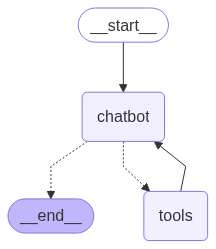

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input:str):
    for event in graph.stream(
        {
            "messages": [{"role": "user", "content": user_input}],
            "user_email":"junjiedai@zju.edu.cn",
        },
        # config
    ):
        for value in event.values():
            if value['messages']:
                value['messages'][-1].pretty_print()

stream_graph_updates("你好，三峡大坝在哪里,顺便搜索下最近有什么旅游活动，使用搜索工具")

================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_717c45753e7445c386f301)
 Call ID: call_717c45753e7445c386f301
  Args:
    query: 三峡大坝位置 最近旅游活动
    search_depth: advanced
    include_images: False
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "三峡大坝位置 最近旅游活动", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://hk.trip.com/moments/poi-three-gorges-dam-tourism-100965/", "title": "【2025宜昌景點】三峽大壩旅遊區旅遊攻略（於8月更新） - Trip.com", "content": "三峽工程大酒店限時免費遊，背誦詩詞贏景區直通車票. 6月30日至9月30日，三峽工程大酒店推出「詩意三峽免費遊禮」活動。入住酒店，背誦三峽相關詩詞全文及作者姓名，即可獲得", "score": 0.5999311, "raw_content": null}, {"url": "https://zh.wikipedia.org/zh-hans/%E9%95%BF%E6%B1%9F%E4%B8%89%E5%B3%A1%E6%B0%B4%E5%88%A9%E6%9E%A2%E7%BA%BD%E5%B7%A5%E7%A8%8B", "title": "长江三峡水利枢纽工程 - 维基百科", "content": "分布在重庆市到湖北省宜昌市的长江干流上，大坝位于长江三峡西陵峡内的宜昌市夷陵区三斗坪，并和其下游38千米的葛洲坝水电站形成梯级调度电站。 它是